In [ ]:
# Import core libraries for data handling and visualization
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# System and warning configuration
import os
import warnings
warnings.filterwarnings('ignore')  # Hide warnings for cleaner output
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # Prevent MKL duplication error (especially on Mac)

mpl.rcParams['figure.dpi'] = 300
plt.rc('font', size=7)           # controls default text sizes
plt.rc('axes', titlesize=7)      # fontsize of the axes title
plt.rc('axes', labelsize=7)      # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)     # fontsize of the tick labels
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('figure', titlesize=10)    # fontsize of the figure title


### Helper Function: Violin Plot by Sex and Generation

This helper function creates a violin plot showing the distribution of a given feature (col) for males and females within a specific generation.
Violin plots combine boxplots with kernel density plots, helping visualize both summary statistics and distribution shape.

In [2]:
#Helper functions

def plot_violin_gen(data, col, gen = 1):
    """Shows the distribution of the specified column and generation by Sex

    Args:
        data (pd.DataFrame): Data to plot from
        col (str): Column to plot distribution
        gen (int, optional): Generation to filter by. Defaults to 1.
    """
    if data[col].dtype == 'object':
        raise ValueError(f"Column '{col}' must be numeric to plot grouped means.")

    df_cpy = data.loc[data['Generation'] == gen, [col, 'Sex']].copy()
    sns.violinplot(df_cpy, y=col, hue='Sex')
    plt.title(f'Distribution of {col} for Generation {gen}', fontsize=16)
    plt.show()


def plot_grouped(data, col, divide_by_group = True):
    """Plots grouped mean valuesa as bar plots through generations

    Args:
        data (pd.DataFrame): Data to plot from
        col (str): Column to plot grouped bar plots for
        divide_by_group (bool): Defaults to True. Determines to plot by Sex or by Group.
    """

    if data[col].dtype == 'object':
        raise ValueError(f"Column '{col}' must be numeric to plot grouped means.")

    divider = 'Group' if divide_by_group else 'Sex'
    df_cpy = data[['Generation', divider, col]].copy()
    df_cpy = df_cpy.groupby(['Generation', divider])[col].mean().reset_index()
    sns.barplot(df_cpy, x='Generation', y=col, hue=divider)
    plt.title(f'Average {col} by Generation and {divider}', fontsize=16)
    plt.show()


### Parameter Configuration

This dictionary defines global parameters for filtering, feature selection, and reproducibility. These parameters are reused across cells to ensure consistent logic for:
- Selecting modeling features
- Splitting data by generation
- Excluding metadata or string-based columns

In [3]:
# Define global parameters for filtering, exclusion, and reproducibility
params = { 
    'for_ml' : '../processed/ambitus_0_15_ml_ready_04_08_2025.csv', # Path to preprocessed ML-ready data
    'raw_data': "../raw/ambitus_0_15_log_04_08_2025.parquet",
    'str_cols' : ['Group', 'Sex', 'Season'], # Categorical string columns
    'not_for_ml' : ['Group', 'Sex', 'Season', 'NR', 'Year', 'Paradigm', 'id', 'Generation'], # Columns excluded from modeling
    'not_corr_cols' : ['Group', 'Sex', 'Season', 'NR', 'Year', 'Paradigm', 'id', 'Generation', 'Group'], # Excluded from correlation
    'generation_cut' : 13, # Upper limit for training/test split
    'generation_under_cut' : 6, # Lower limit for training data
    'seed' : 42 # Seed for reproducibility
}

### Load and Prepare the Data

We load the behavioral dataset from a .parquet file into a DataFrame and standardize the Sex columns to lowercase ('GR_Sex', 'Sex') to ensure consistency. This step avoids downstream grouping or filtering issues due to inconsistent casing (e.g., "Male" vs. "male").

In [4]:
# set the data path
file_path = params['raw_data']
# load the data into a DataFrame
df = pd.read_parquet(file_path)
df['GR_Sex'] = df['GR_Sex'].str.lower()
df['Sex'] = df['Sex'].str.lower()

### Spearman Correlation Matrix

To explore associations between behavioral features, we compute a Spearman correlation matrix after:
- Removing categorical and metadata columns (e.g., IDs, trial info)
- Keeping only numeric columns with sufficient variance
- Calculating non-parametric (rank-based) correlations

This plot reveals monotonic relationships between features and helps identify clusters, redundancies, or candidate variables for dimensionality reduction or modeling.

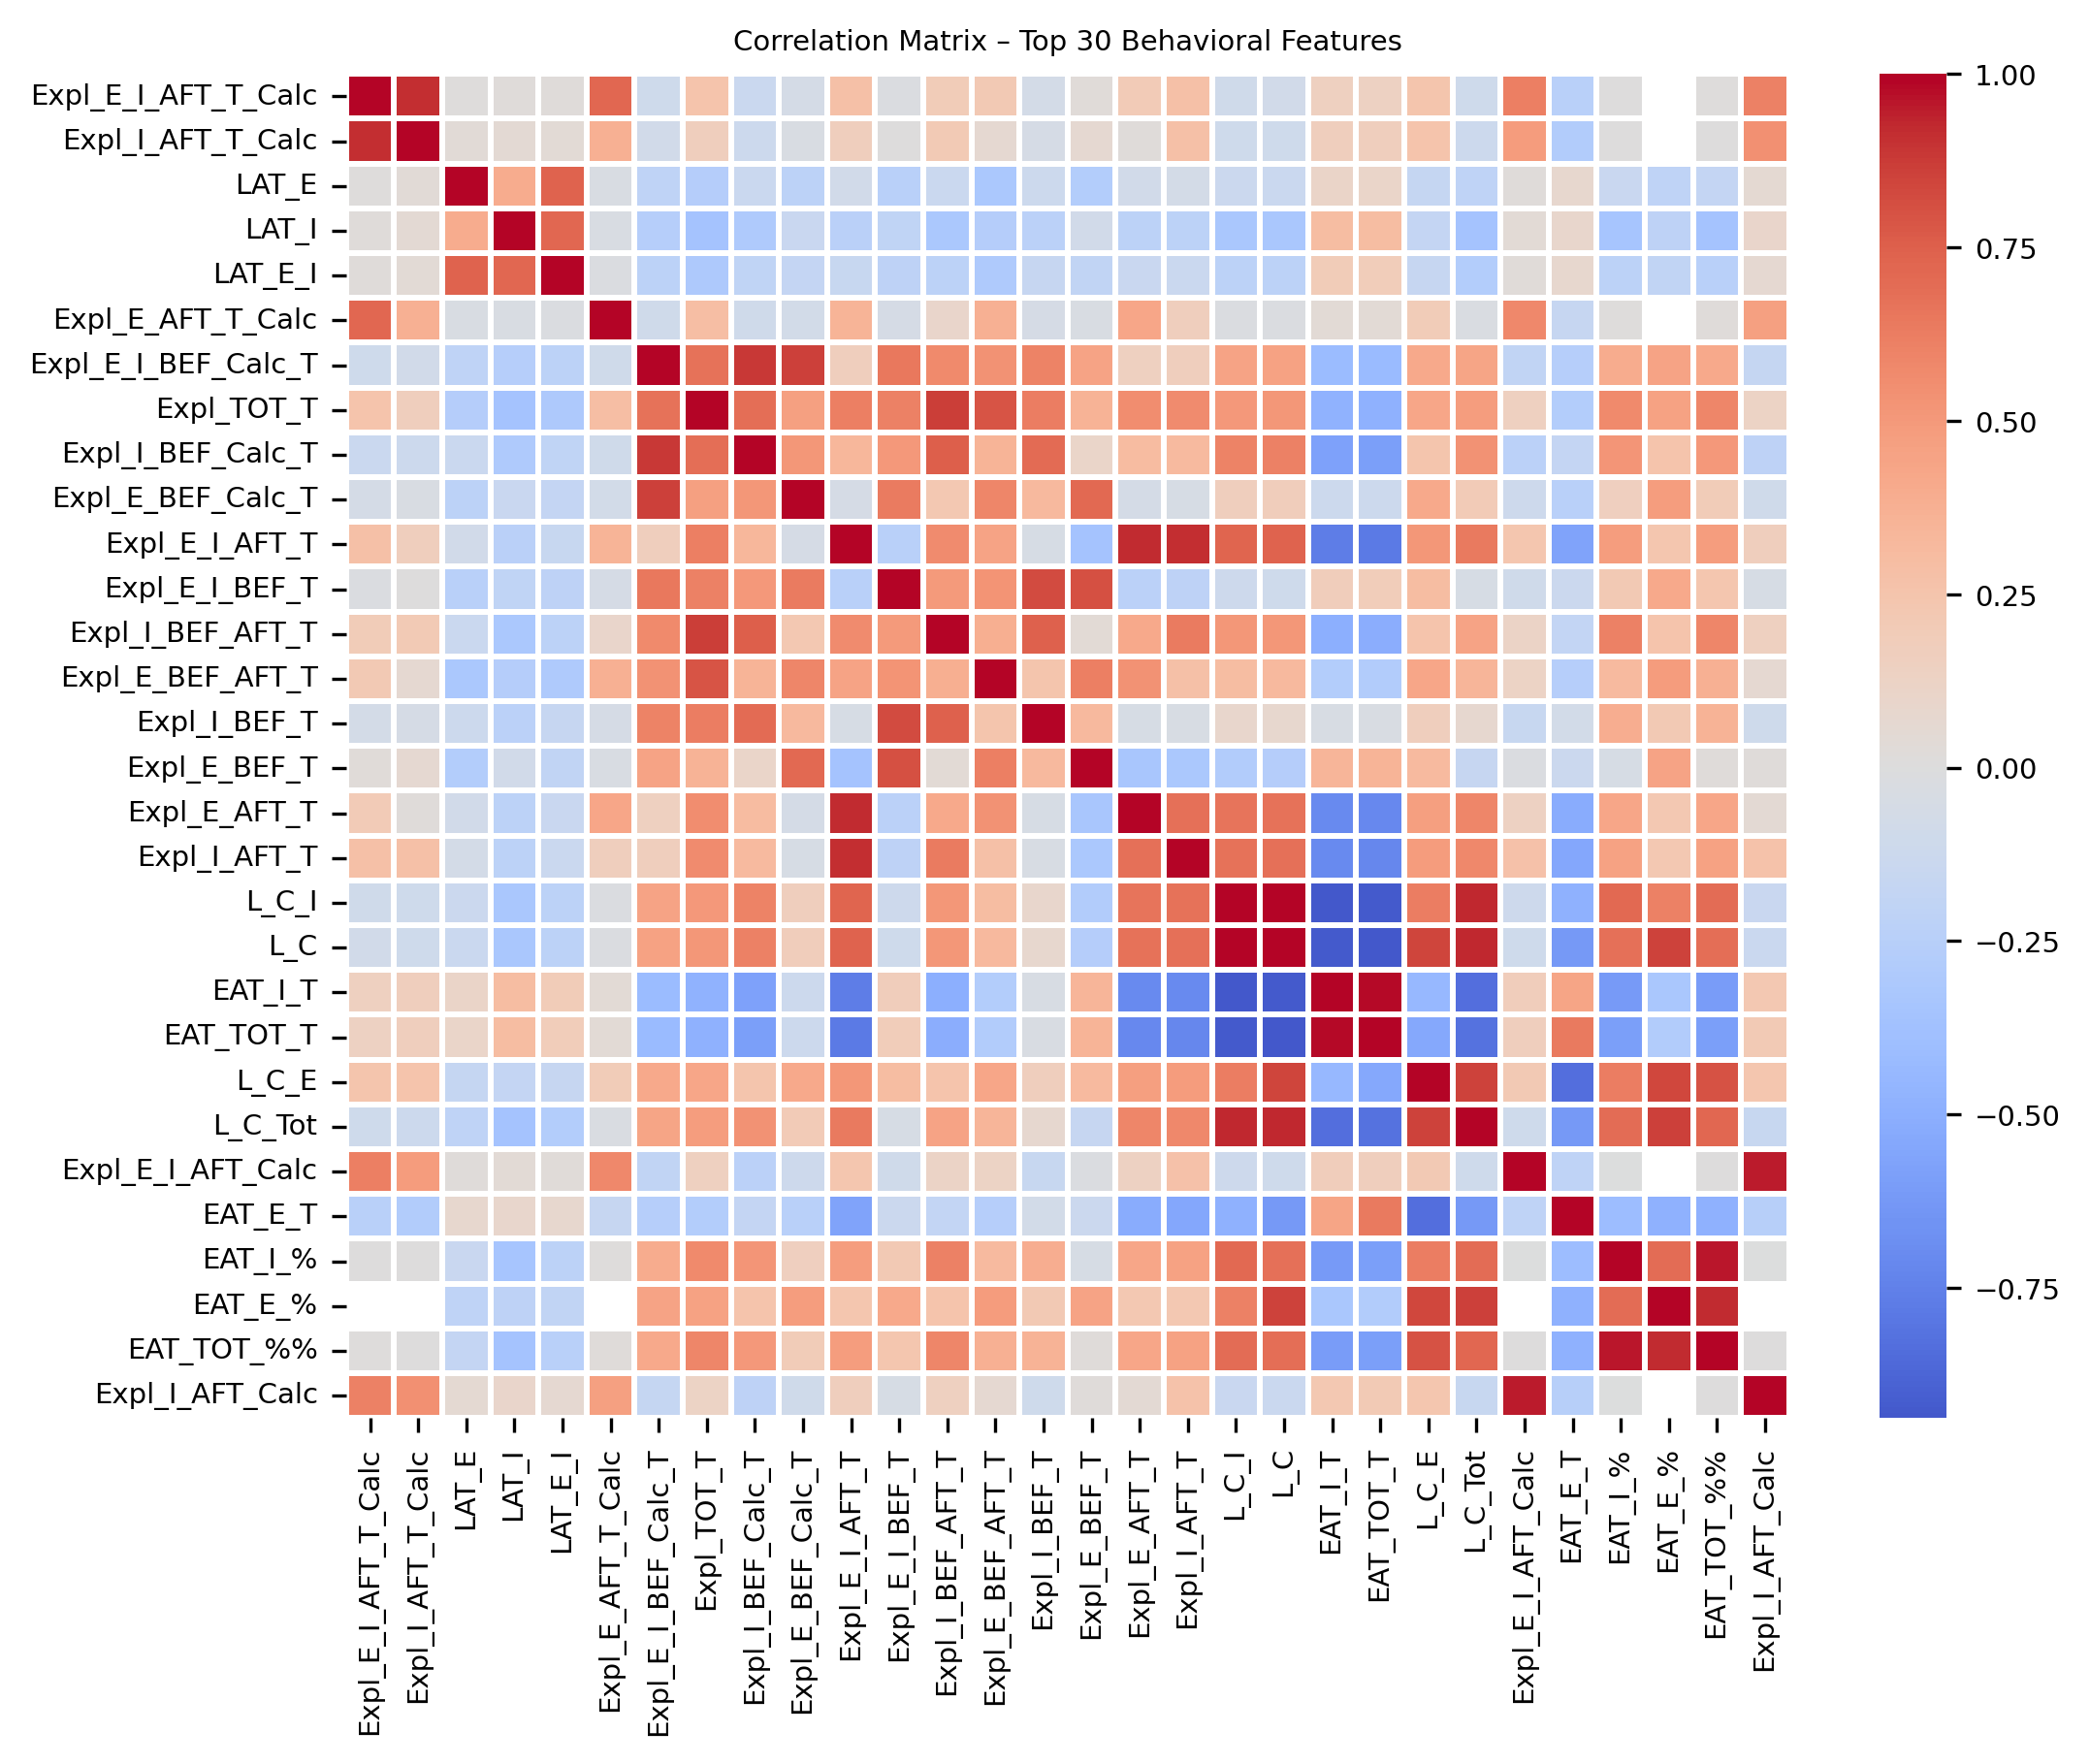

In [13]:
# Drop categorical / identifier columns that are not behavioral features
exclude_keywords = ['id', 'group', 'sex', 'trial', 'year', 'gen', 'rat', 'animal']
exclude_columns = [col for col in df.columns if any(key in col.lower() for key in exclude_keywords)]
df_filtered = df.drop(columns=exclude_columns, errors='ignore')

# Keep only numeric columns
df_numeric = df_filtered.select_dtypes(include='number')

# Drop columns with constant values or near-zero variance
df_numeric = df_numeric.loc[:, df_numeric.std() > 0.01]

# Select top 30 variables by standard deviation
top30_columns = df_numeric.std().sort_values(ascending=False).head(30).index
df_top30 = df_numeric[top30_columns]

# Plot the correlation result

plt.figure(figsize=(8, 6))
sns.heatmap(df_top30.corr(), cmap="coolwarm", center=0, annot=False, fmt=".2f", linewidths=1)
plt.title("Correlation Matrix – Top 30 Behavioral Features")
# show figure
plt.show()

### Data Cleaning and Grouping

Before visualizing group-level distributions, we:
- Drop rows missing key metadata (GR_Sex, Year)
- Standardize and prepare the Group_Sex column for plotting (e.g., combining Sex and group labels)

This step ensures consistent grouping across all visualizations.

In [6]:
# Drop rows with missing values in Group_Sex or Year
df_clean = df.dropna(subset=['GR_Sex', 'Year'])

# Standardize Group_Sex values to lowercase
df_clean['Group_Sex'] = df_clean['GR_Sex'].str.lower()

### Feature Selection for Visualization

We define a dictionary of key behavioral metrics and their human-readable labels. These will be used in plots to ensure clarity and interpretability when presenting group-wise differences.

You can add or remove features depending on your focus (e.g., cognitive traits, motor activity, exploration patterns).

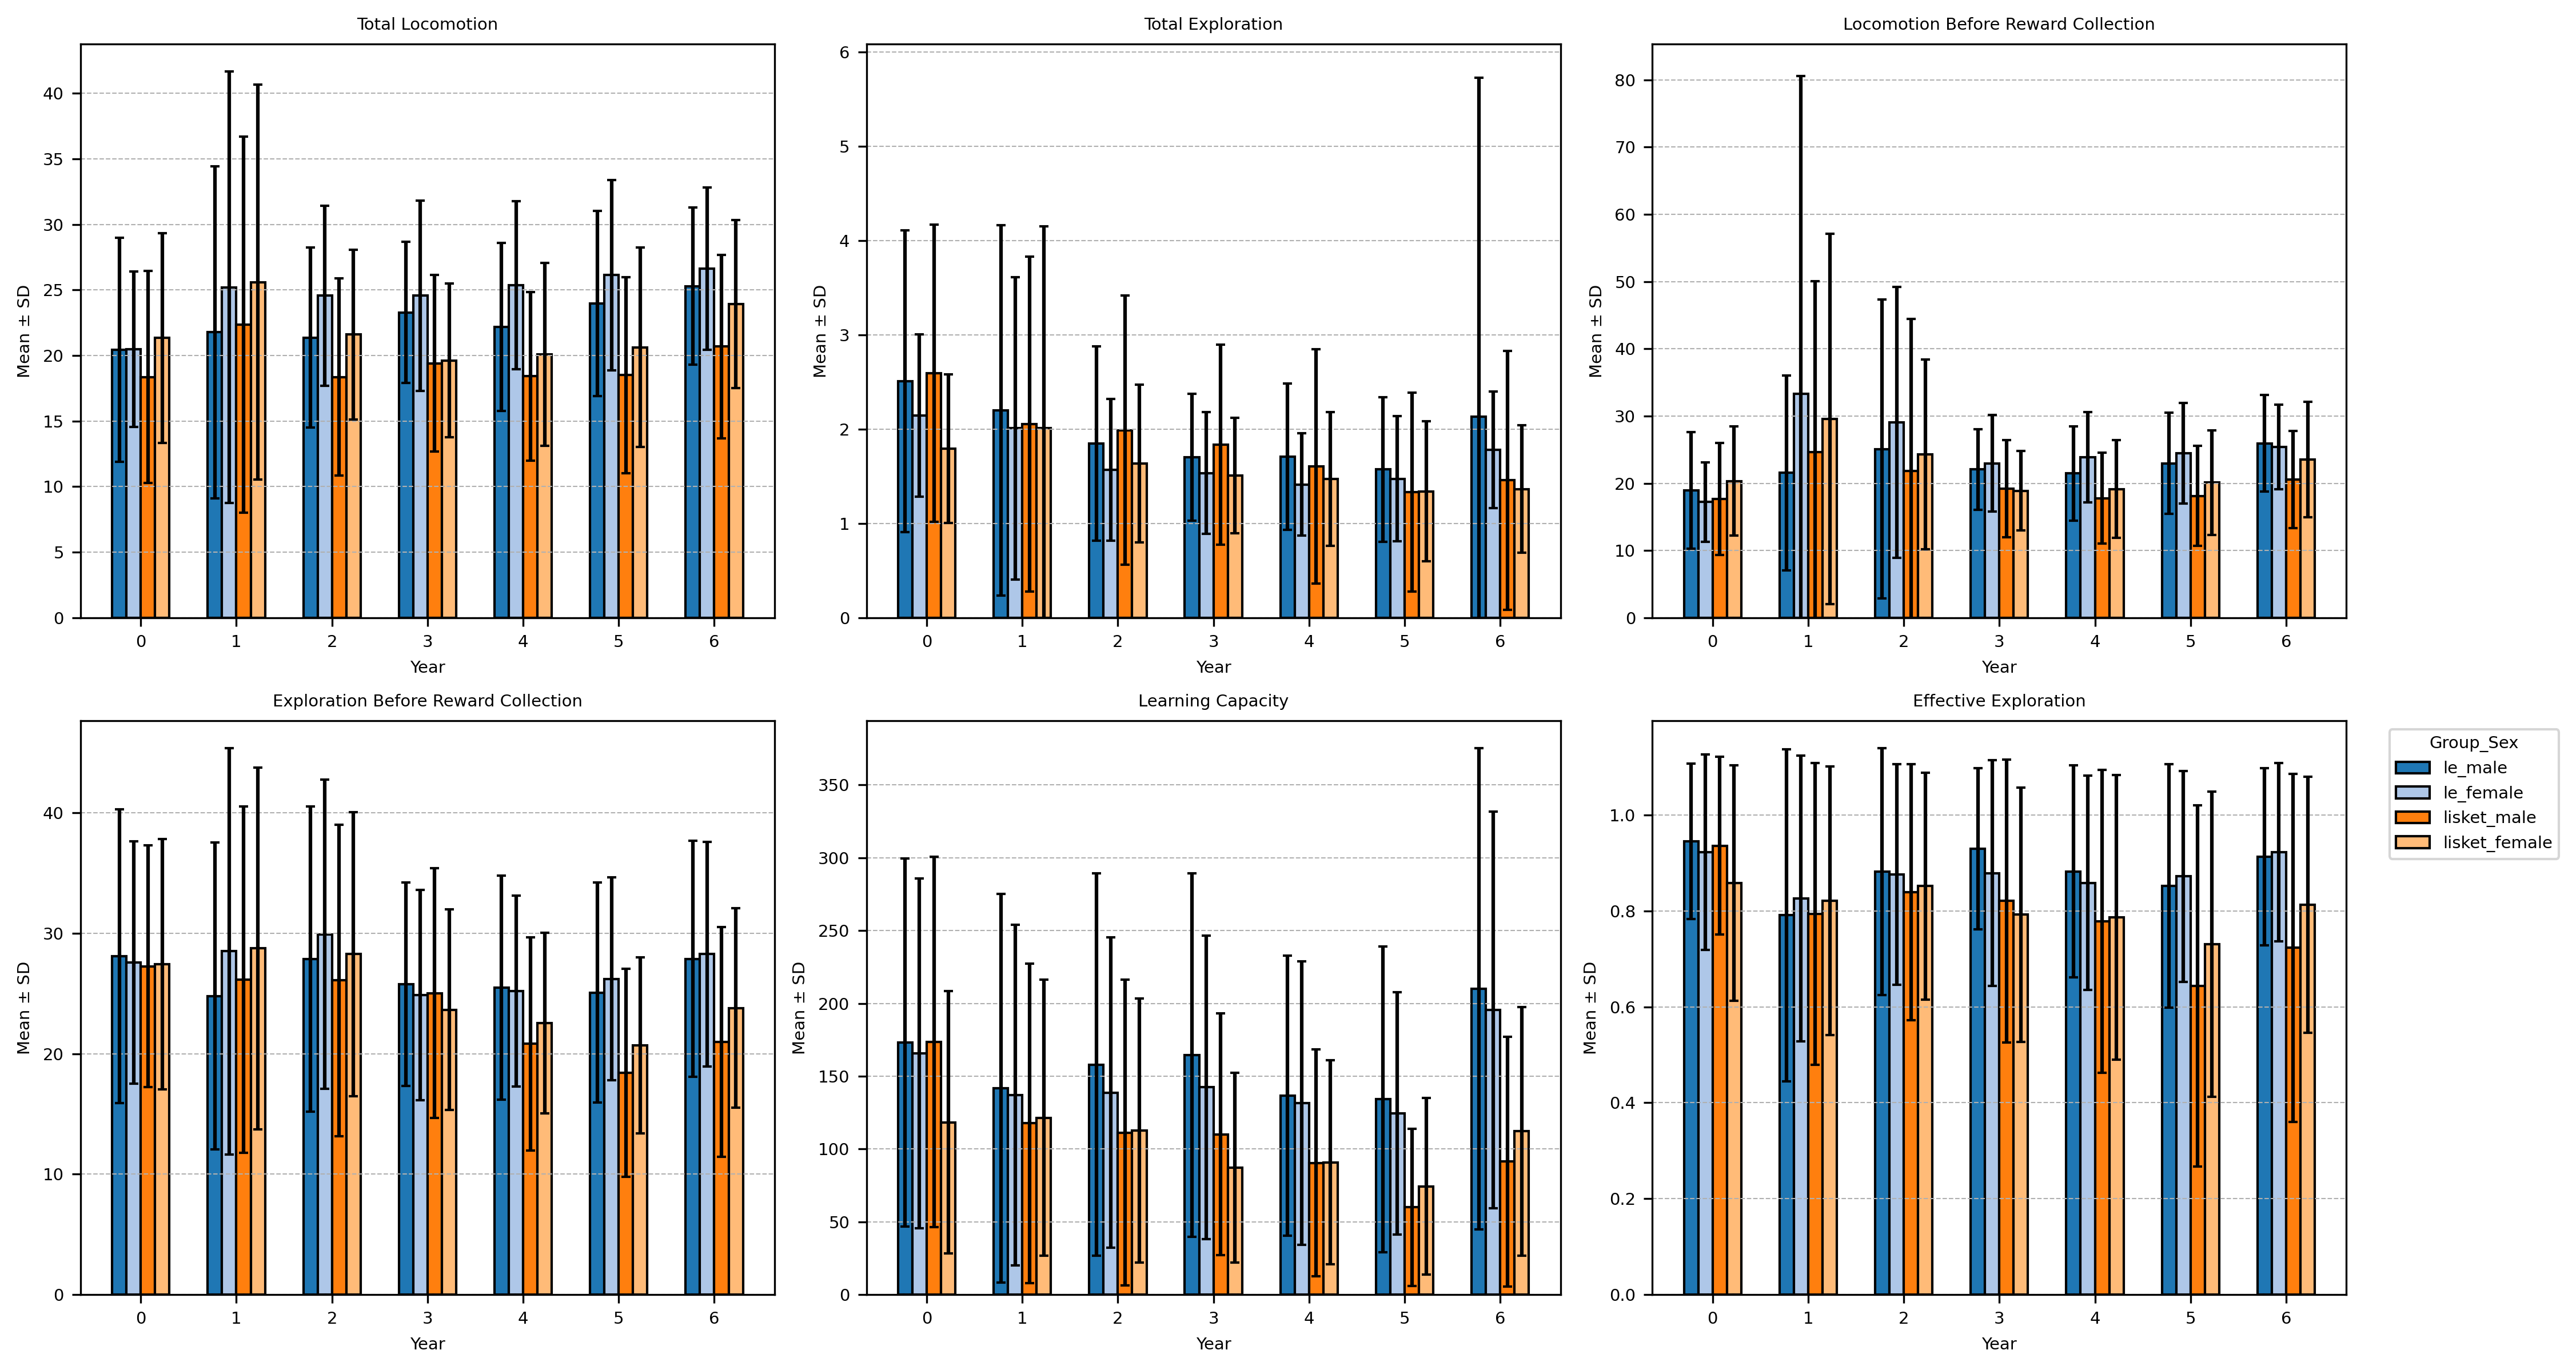

In [7]:
# Define same 6 features with new group-based color style
features = {
    'LOCO_TOT': 'Total Locomotion',
    'Expl_E_I_TOT_Loco_ratio': 'Total Exploration',
    'LOCO_BEF': 'Locomotion Before Reward Collection',
    'Expl_E_I_BEF_Nr': 'Exploration Before Reward Collection',
    'L_C': 'Learning Capacity',
    'E_E': 'Effective Exploration'
}

# Color palette for groups in a color version
color_palette = {
    'le_male': '#1f77b4',
    'le_female': '#aec7e8',
    'lisket_male': '#ff7f0e',
    'lisket_female': '#ffbb78'
}
plot_groups = list(color_palette.keys())

# Prepare figure
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Draw color version of 6 feature-wise plots
for ax, (feature, title) in zip(axes, features.items()):
    summary = df_clean.groupby(['Year', 'Group_Sex'])[feature].agg(['mean', 'std']).reset_index()
    years = sorted(df_clean['Year'].dropna().unique())
    width = 0.15

    for i, group in enumerate(plot_groups):
        group_data = summary[summary['Group_Sex'] == group]
        x = np.array(group_data['Year']) + (i - 1.5) * width
        ax.bar(x, group_data['mean'], width=width,
               yerr=group_data['std'], capsize=2,
               color=color_palette[group],
               edgecolor='black', label=group)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Mean ± SD")
    ax.set_xticks(years)
    ax.set_xticklabels(years)
    ax.set_ylim(bottom=0)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

axes[-1].legend(title="Group_Sex", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Summary Statistics Across Generations

In the next section, we will compare selected behavioral metrics across different generations to explore potential longitudinal trends or cohort effects.

In [8]:
# Filter out rows with missing Sex, Year, or Group
df_filtered = df.dropna(subset=["Sex", "Year", "Group"])
df_filtered = df_filtered.drop_duplicates(subset=["Year", "Generation", "Group", "Sex","NR"])

# Count animals by Year, Group, and Sex
grouped = df_filtered.groupby(["Year", "Generation", "Group", "Sex"]).size().unstack(fill_value=0)

# Rename columns to match the template
grouped = grouped.rename(columns={"male": "Nr animals Male", "female": "Nr animals Female"})

# Add total animal count
grouped["Nr animals"] = grouped["Nr animals Male"] + grouped["Nr animals Female"]

# Reset index to flatten DataFrame
summary_df = grouped.reset_index()

In [9]:
summary_df

Sex,Year,Generation,Group,Nr animals Female,Nr animals Male,Nr animals
0,0,0,LE,14,27,41
1,0,0,Lisket,15,26,41
2,1,1,LE,22,31,53
3,1,1,Lisket,18,29,47
4,1,2,LE,15,15,30
5,1,2,Lisket,27,30,57
6,1,3,LE,20,29,49
7,1,3,Lisket,20,40,60
8,2,4,LE,20,20,40
9,2,4,Lisket,20,30,50


### Sex-wise Trend of Behavioral Feature Across Generations

This plot shows how the average value of the selected behavioral metric
Expl_E_I_TOT_Loco_ratio_4 (likely related to exploratory locomotion) evolves across generations, separated by Sex.

You can replace the feature name in the function call to explore trends for other variables as well.

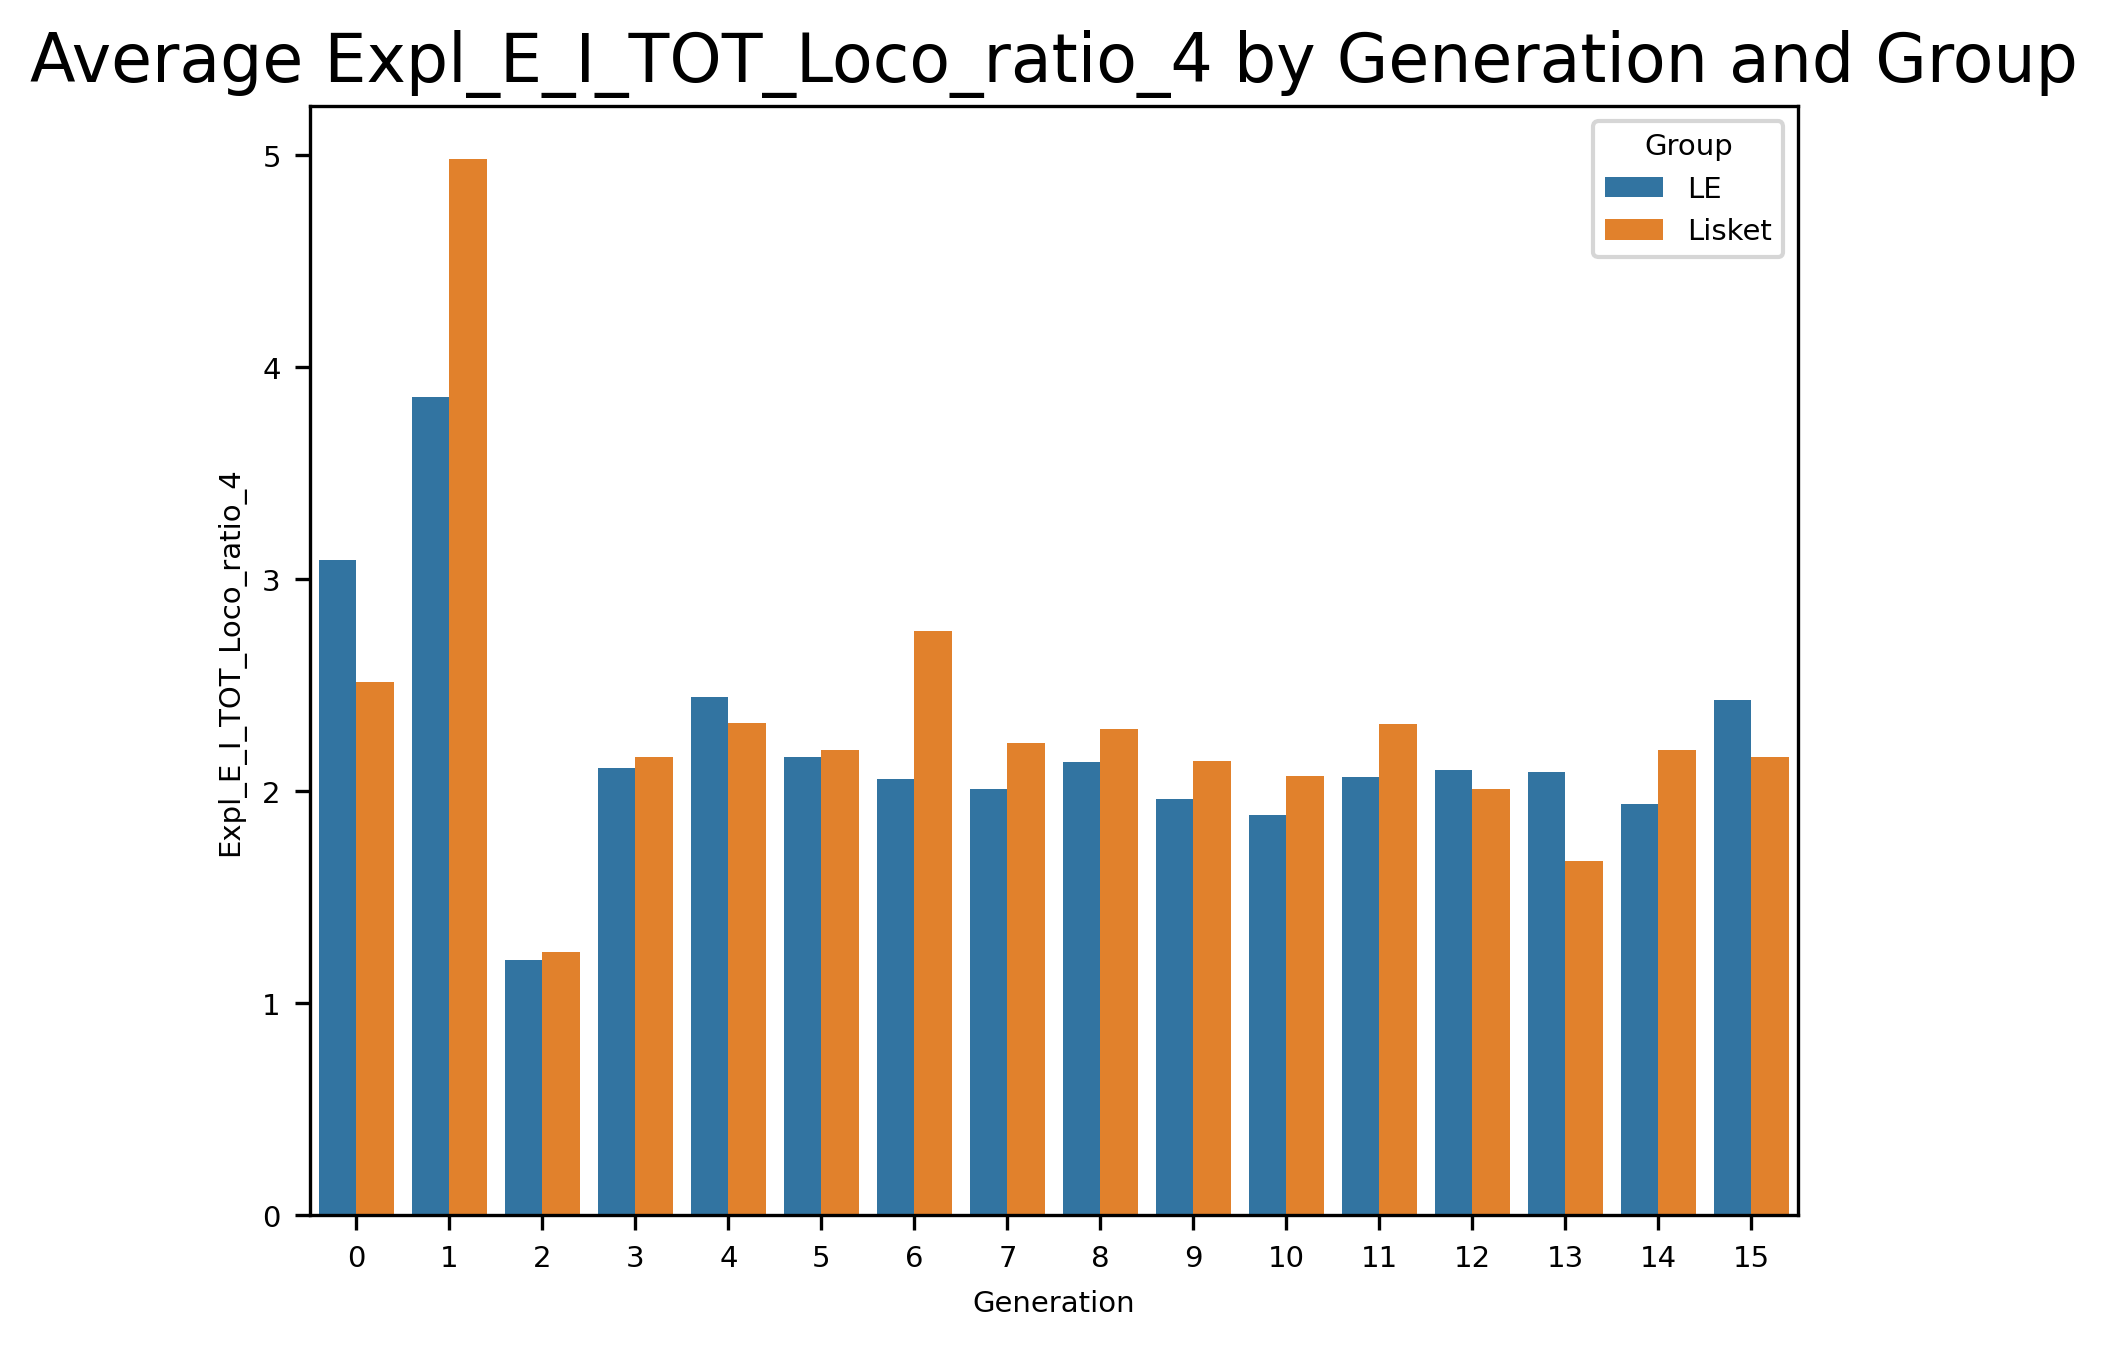

In [10]:
#Plotting the mean value through the generations and by Sexs
#Readading the data
data = pd.read_csv(params['for_ml'])
plot_grouped(data, 'Expl_E_I_TOT_Loco_ratio_4')

### Violin Plot: Sex Differences in a Single Generation

This visualization shows the distribution of the feature EAT_E_% in Generation 4, separated by Sex.

Violin plots display both the distribution shape (via KDE) and summary statistics (median, quartiles), making it easy to spot differences in variability and central tendency.

You can try:
- Changing the feature (e.g., 'L_C', 'Expl_TOT')
- Visualizing a different generation (e.g., gen=7)

### Group Distribution Across Generations

To understand the target variable (Group) over time, we plot its distribution by generation.
This helps evaluate:
- Whether some groups dominate in specific generations
- Potential bias in modeling based on generational imbalance

You can use this insight to inform your training/test split or apply resampling methods.

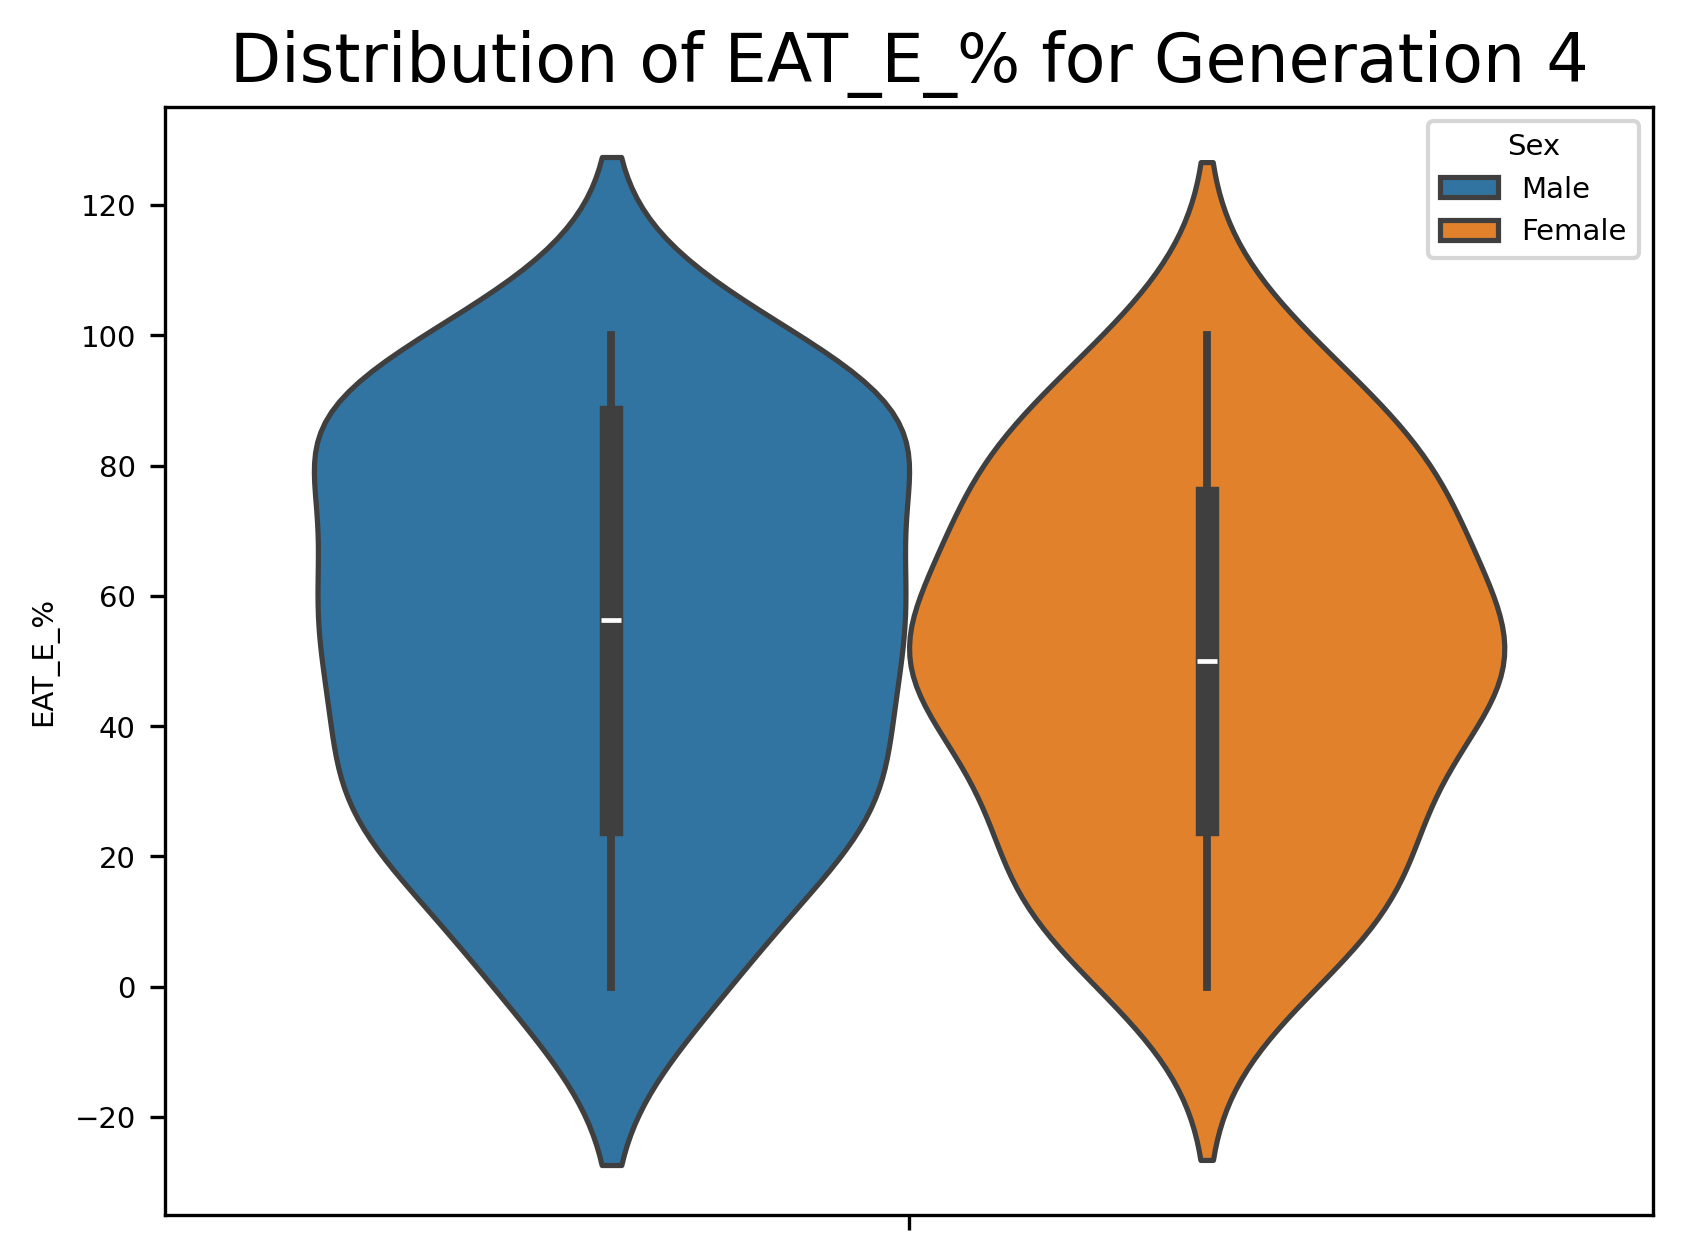

In [11]:
plot_violin_gen(data, 'EAT_E_%', 4)

### Group Distribution – Overall and by Generation

We visualize the class distribution (Group) in two ways:
- By generation: reveals how group membership varies over time.
This helps detect potential sampling bias or temporal drift.
- Overall distribution: helps assess class balance, which is critical before training a classifier.

If one group dominates:
- Consider class weighting, resampling, or stratified splitting for fair model training.


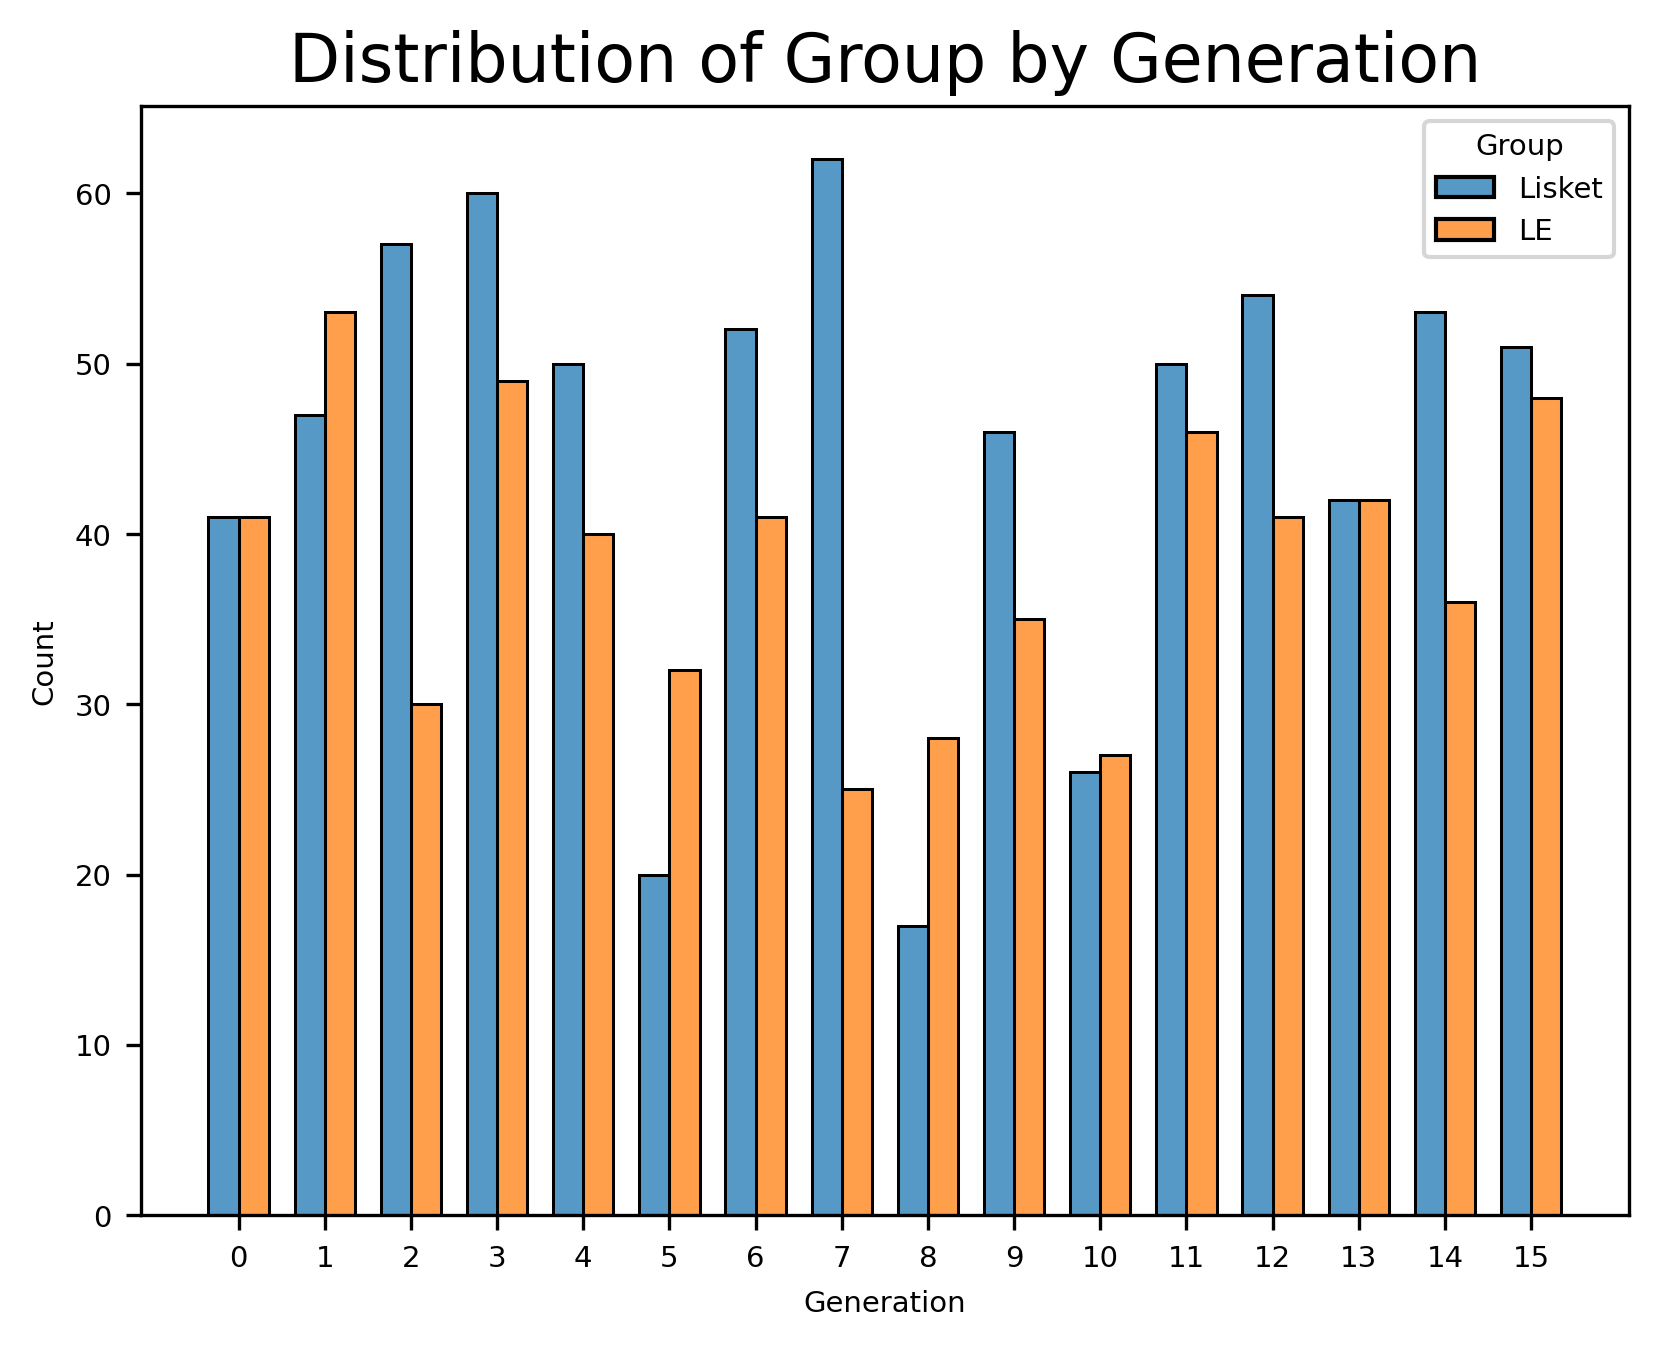

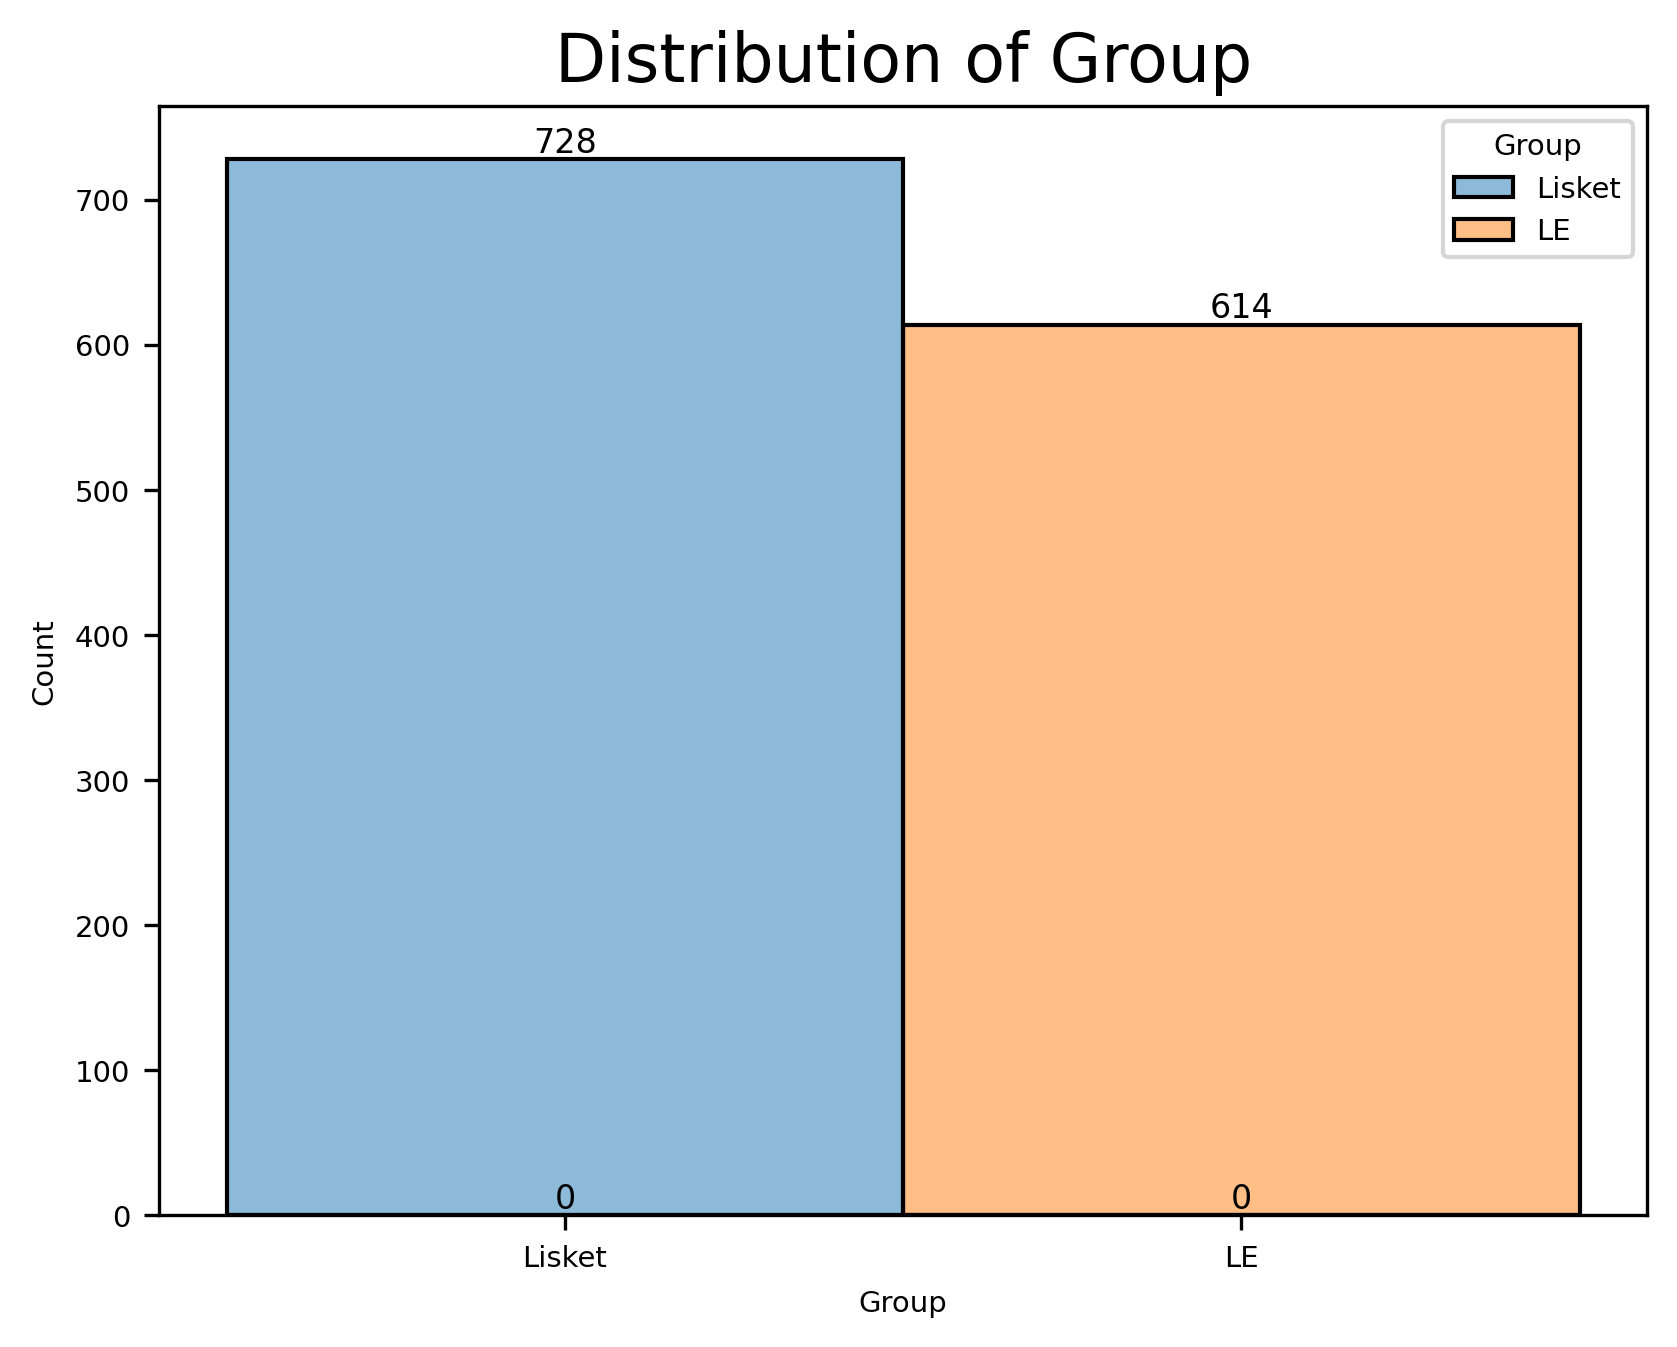

In [12]:
# Ensure 'Generation' is treated as numeric
data['Generation'] = pd.to_numeric(data['Generation'])
# Plot the distribution of Group labels across generations
ax = sns.histplot(data, x='Generation', multiple='dodge', hue='Group', shrink= 0.7, discrete = True, binwidth=0.5)
# ax.bar_label(ax.containers[0], label_type='edge', fontsize=8)
# ax.bar_label(ax.containers[1], label_type='edge', fontsize=8)
ax.set_xticks(range(0, 16))
plt.title('Distribution of Group by Generation', fontsize=16)
plt.show()

#Group label distribution over all generations
ax = sns.histplot(data, x='Group', hue='Group')
ax.bar_label(ax.containers[0], label_type='edge', fontsize=8)
ax.bar_label(ax.containers[1], label_type='edge', fontsize=8)
plt.title('Distribution of Group', fontsize=16)
plt.show()